In [217]:
import os
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderNotFound
from geopy.extra.rate_limiter import RateLimiter
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
from sklearn.cluster import KMeans
import urllib.request as ur
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from IPython.display import Image



In [5]:
with open('./Data/NSW_map.geojson') as json_data:
    NSW_map = json.load(json_data)
NSW_map_feature = NSW_map['features']
len(NSW_map_feature)

4592

In [6]:
# Extract suburb names from geojson file
suburb_list_geojson = []
for suburb in NSW_map_feature :
    suburb_list_geojson.append(suburb['properties']['nsw_loca_2'])

# Covert the list to dataframe
suburb_list_geojson_df = pd.DataFrame(suburb_list_geojson, columns=['Suburbs_boundaries'])

# Add one more column as key column for merging
suburb_list_geojson_df['Suburb_key'] = suburb_list_geojson_df['Suburbs_boundaries'].str.title()



In [27]:
# specify which URL/web page we are going to be scraping from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_Sydney_suburbs"

# open the url using urllib.request and put the HTML into the page variable
page = ur.urlopen(url)

# import the BeautifulSoup library so we can parse HTML and XML documents
from bs4 import BeautifulSoup

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "html.parser")

project_title = [i['title'] for i in soup.find_all('a', title=True)]

# filter list of suburbs to only valid values
suburb_list= filter(lambda item: ', New South Wales' in item , project_title)
suburb_list= list(filter(lambda item: 'List of ' not in item , suburb_list))
suburb_list.sort(reverse=False)
address_wiki=[i.split(',', 1)[0] for i in suburb_list]

In [23]:
# Mesh Blocks Data obtained from ABS Census 2016
df_MB=pd.read_csv('./Data/Census_2016/MB_2016_NSW.csv')
df_MB.head()

MB_CODE_2016 MB_CATEGORY_NAME_2016  SA1_MAINCODE_2016  SA1_7DIGITCODE_2016  \
0   10000009499      NOUSUALRESIDENCE        19999949999              1949999   
1   10000010000           Residential        10901117207              1117207   
2   10000021000            Commercial        10901117612              1117612   
3   10000022000            Commercial        10901117621              1117621   
4   10000023000            Commercial        10901117621              1117621   

   SA2_MAINCODE_2016  SA2_5DIGITCODE_2016           SA2_NAME_2016  \
0          199999499                19499  No usual address (NSW)   
1          109011172                11172           Albury - East   
2          109011176                11176               Lavington   
3          109011176                11176               Lavington   
4          109011176                11176               Lavington   

   SA3_CODE_2016           SA3_NAME_2016  SA4_CODE_2016  \
0          19999  No usual address (NSW)            199   
1          10901                  Albury            109   
2          10901                  Albury            109   
3          10901                  Albury            109   
4          10901                  Albury            109   

            SA4_NAME_2016 GCCSA_CODE_2016         GCCSA_NAME_2016  \
0  No usual address (NSW)           19499  No usual address (NSW)   
1                  Murray           1RNSW             Rest of NSW   
2                  Murray           1RNSW             Rest of NSW   
3                  Murray           1RNSW             Rest of NSW   
4                  Murray           1RNSW             Rest of NSW   

   STATE_CODE_2016  STATE_NAME_2016  AREA_ALBERS_SQKM  
0                1  New South Wales            0.0000  
1                1  New South Wales            0.0209  
2                1  New South Wales            0.0829  
3                1  New South Wales            0.0388  
4                1  New South Wales            0.0254

(58819, 16)

In [47]:
# Read in SSC (Suburb Data) as Dataframe
df_SSC=pd.read_csv('./Data/Census_2016/SSC_2016_AUST.csv')
df_SSC=pd.merge(df_SSC,df_MB[['MB_CODE_2016','GCCSA_NAME_2016']],on='MB_CODE_2016',how='inner')
df_SSC.head()

MB_CODE_2016  SSC_CODE_2016 SSC_NAME_2016  STATE_CODE_2016  \
0   10310310000          12402    Lower Boro                1   
1   10310350000          12402    Lower Boro                1   
2   10310330000          12402    Lower Boro                1   
3   11204634100          13062        Oallen                1   
4   11205382200          13062        Oallen                1   

   STATE_NAME_2016  AREA_ALBERS_SQKM GCCSA_NAME_2016  
0  New South Wales           38.6513     Rest of NSW  
1  New South Wales           55.4296     Rest of NSW  
2  New South Wales           19.7428     Rest of NSW  
3  New South Wales          119.0986     Rest of NSW  
4  New South Wales           72.1115     Rest of NSW

In [48]:
# Remove areas outside of Greater Sydney
df_SSC=df_SSC[df_SSC['GCCSA_NAME_2016'].str.contains('Sydney')]
df_SSC.head()

MB_CODE_2016  SSC_CODE_2016 SSC_NAME_2016  STATE_CODE_2016  \
5196   10951980000          10114   Avoca Beach                1   
5197   10292150000          10114   Avoca Beach                1   
5198   10292140000          10114   Avoca Beach                1   
5199   10284530000          10114   Avoca Beach                1   
5200   11205634800          10114   Avoca Beach                1   

      STATE_NAME_2016  AREA_ALBERS_SQKM GCCSA_NAME_2016  
5196  New South Wales            0.6349  Greater Sydney  
5197  New South Wales            0.1056  Greater Sydney  
5198  New South Wales            0.7151  Greater Sydney  
5199  New South Wales            0.0650  Greater Sydney  
5200  New South Wales            0.0711  Greater Sydney

In [49]:
# filter further to only retain the SSC code and name for list of suburbs as outlined in Wiki

address= df_SSC['SSC_NAME_2016'].apply(lambda x: x.split(' -')[0])
address=[i.split(' (', 1)[0] for i in address]
address=[i.split(' Industrial', 1)[0] for i in address]
#address = [i+', Sydney' for i in address]
df_SSC['SSC_NAME_2016']=address
address_abs=list(dict.fromkeys(address))
set_wiki=set(address_wiki)
address_abs=[x for x in address_abs if x in set_wiki]
len(address_abs)

672

In [50]:
SSC_Code=[]
for name in address_abs:
    C = df_SSC['SSC_NAME_2016']==name
    SSC_Code.append(df_SSC.loc[C, 'SSC_CODE_2016'].iat[0])

len(SSC_Code)

ssc_dict = {'Suburb': address_abs,'SSC_Code': SSC_Code}
df_address_SSC=pd.DataFrame(ssc_dict)
df_address_SSC['Suburb'] =  df_address_SSC['Suburb'].astype(str)+', Sydney'
df_address_SSC['SSC_Code'] = 'SSC'+ df_address_SSC['SSC_Code'].astype(str)
df_address_SSC.sort_values(by='Suburb',inplace=True)
df_address_SSC.reset_index(drop=True,inplace=True)
address_abs=df_address_SSC['Suburb'].to_list()
df_address_SSC.head()


Suburb  SSC_Code
0      Abbotsbury, Sydney  SSC10002
1      Abbotsford, Sydney  SSC10003
2  Acacia Gardens, Sydney  SSC10014
3     Agnes Banks, Sydney  SSC10021
4           Airds, Sydney  SSC10022

In [51]:
geolocater= Nominatim(user_agent="sydney-explorer")
suburb=[]
empty=[]

def getcoords(add):
    try:
        coords= geolocater.geocode(add, timeout=10)
        suburb.append([add, coords.latitude, coords.longitude])
        print("the coords are {}".format(suburb[-1]))
    
    except GeocoderTimedOut:
        return getcoords(add)
    
    except:
        empty.append([add])
        print("Couldn't find coords of {}".format(empty[-1]))
        
for add in address_abs:
        getcoords(add)


the coords are ['Abbotsbury, Sydney', -33.8692846, 150.8667029]
the coords are ['Abbotsford, Sydney', -33.8505529, 151.129759]
the coords are ['Acacia Gardens, Sydney', -33.7324595, 150.9125321]
the coords are ['Agnes Banks, Sydney', -33.6145082, 150.7114482]
the coords are ['Airds, Sydney', -34.09, 150.8261111]
the coords are ['Alexandria, Sydney', -33.9091568, 151.1921281]
the coords are ['Alfords Point, Sydney', -33.9839091, 151.0241615]
the coords are ['Allambie Heights, Sydney', -33.7705067, 151.249675]
the coords are ['Allawah, Sydney', -33.9696293, 151.1142847]
the coords are ['Ambarvale, Sydney', -34.0844252, 150.8017477]
the coords are ['Annandale, Sydney', -33.881224, 151.1709976]
the coords are ['Annangrove, Sydney', -33.6574838, 150.9460077]
the coords are ['Arcadia, Sydney', -33.6227289, 151.0605602]
the coords are ['Arncliffe, Sydney', -33.938236, 151.145508]
the coords are ['Arndell Park, Sydney', -33.79, 150.8761111]
the coords are ['Artarmon, Sydney', -33.808955, 151.1

the coords are ['Chatswood West, Sydney', -33.7960029, 151.1597081]
the coords are ['Chatswood, Sydney', -33.7944797, 151.1818571]
the coords are ['Cheltenham, Sydney', -33.7569444, 151.0775]
the coords are ['Cherrybrook, Sydney', -33.7227778, 151.0461111]
the coords are ['Chester Hill, Sydney', -33.8816667, 151.0011111]
the coords are ['Chifley, Sydney', -33.9702813, 151.2394867]
the coords are ['Chippendale, Sydney', -33.8863291, 151.1998211]
the coords are ['Chipping Norton, Sydney', -33.919687, 150.9630711]
the coords are ['Chiswick, Sydney', -33.8498337, 151.1378781]
the coords are ['Chullora, Sydney', -33.8925, 151.0477778]
the coords are ['Church Point, Sydney', -33.6500957, 151.2853102]
the coords are ['Claremont Meadows, Sydney', -33.7691667, 150.7483333]
the coords are ['Clarendon, Sydney', -33.6105511, 150.7888909]
the coords are ['Clareville, Sydney', -33.6320071, 151.3145323]
the coords are ['Claymore, Sydney', -34.0469444, 150.81]
the coords are ['Clemton Park, Sydney', -

the coords are ['Glenmore Park, Sydney', -33.7887972, 150.669496]
the coords are ['Glenorie, Sydney', -33.5658885, 150.9927835]
the coords are ['Glenwood, Sydney', -33.7331483, 150.928232]
the coords are ['Glossodia, Sydney', -33.5334431, 150.7853962]
the coords are ['Gordon, Sydney', -33.7553899, 151.1518099]
the coords are ['Granville, Sydney', -33.8345097, 151.0060111]
the coords are ['Grasmere, Sydney', -34.0579584, 150.6707384]
the coords are ['Grays Point, Sydney', -34.0591451, 151.0786995]
the coords are ['Great Mackerel Beach, Sydney', -33.591505, 151.2988852]
the coords are ['Green Valley, Sydney', -33.9024601, 150.8674187]
the coords are ['Greenacre, Sydney', -33.9022902, 151.058546]
the coords are ['Greendale, Sydney', -33.9150012, 150.6677734]
the coords are ['Greenfield Park, Sydney', -33.8752778, 150.8919444]
the coords are ['Greenhills Beach, Sydney', -34.0360657, 151.1632914]
the coords are ['Greenwich, Sydney', -33.8300104, 151.1855621]
the coords are ['Gregory Hills, 

the coords are ['Manly, Sydney', -33.8038504, 151.2908235]
the coords are ['Maraylya, Sydney', -33.5913984, 150.9221281]
the coords are ['Marayong, Sydney', -33.7491667, 150.8919444]
the coords are ['Maroota, Sydney', -33.4577956, 150.9829191]
the coords are ['Maroubra, Sydney', -33.9453441, 151.2456824]
the coords are ['Marrickville, Sydney', -33.9103854, 151.1556908]
the coords are ['Marsden Park, Sydney', -33.6956552, 150.8147975]
the coords are ['Marsfield, Sydney', -33.7777956, 151.1032015]
the coords are ['Mascot, Sydney', -33.9289562, 151.1951782]
the coords are ['Matraville, Sydney', -33.9639325, 151.2334198]
the coords are ['Mays Hill, Sydney', -33.8205758, 150.9884915]
the coords are ['McGraths Hill, Sydney', -33.615, 150.8344444]
the coords are ['McMahons Point, Sydney', -33.8443387, 151.2027957]
the coords are ['Meadowbank, Sydney', -33.8174993, 151.0884249]
the coords are ['Melrose Park, Sydney', -33.8153435, 151.0733298]
the coords are ['Menai, Sydney', -34.014811, 151.01

the coords are ['Ramsgate, Sydney', -33.982713, 151.1399314]
the coords are ['Randwick, Sydney', -33.914121, 151.2410046]
the coords are ['Redfern, Sydney', -33.8931044, 151.2040292]
the coords are ['Regents Park, Sydney', -33.8820048, 151.02569]
the coords are ['Regentville, Sydney', -33.7708351, 150.6616622]
the coords are ['Revesby Heights, Sydney', -33.9683842, 151.0189891]
the coords are ['Revesby, Sydney', -33.9436876, 151.0137191]
the coords are ['Rhodes, Sydney', -33.8290589, 151.0873578]
the coords are ['Richmond Lowlands, Sydney', -33.5652, 150.7596]
the coords are ['Richmond, Sydney', -33.6009721, 150.7496405]
the coords are ['Riverstone, Sydney', -33.6797545, 150.8616695]
the coords are ['Riverview, Sydney', -33.823207, 151.1600134]
the coords are ['Riverwood, Sydney', -33.9472222, 151.0530556]
the coords are ['Rockdale, Sydney', -33.9542619, 151.1403655]
the coords are ['Rodd Point, Sydney', -33.8658359, 151.143583]
the coords are ['Rookwood, Sydney', -33.8737017, 151.0552

the coords are ['Wetherill Park, Sydney', -33.8483333, 150.9011111]
the coords are ['Whalan, Sydney', -33.7566667, 150.8094444]
the coords are ['Whale Beach, Sydney', -33.6096795, 151.3309449]
the coords are ['Wheeler Heights, Sydney', -33.7286867, 151.2806965]
the coords are ['Wilberforce, Sydney', -33.5566667, 150.8344444]
the coords are ['Wiley Park, Sydney', -33.9230556, 151.0677778]
the coords are ['Willmot, Sydney', -33.7247222, 150.7938889]
the coords are ['Willoughby East, Sydney', -33.7991667, 151.2061111]
the coords are ['Willoughby, Sydney', -33.8063889, 151.2002778]
the coords are ['Windsor Downs, Sydney', -33.6566667, 150.8094444]
the coords are ['Windsor, Sydney', -33.6055342, 150.821953]
the coords are ['Winston Hills, Sydney', -33.7761098, 150.9816606]
the coords are ['Wisemans Ferry, Sydney', -33.3852776, 150.9868024]
the coords are ['Wolli Creek, Sydney', -33.9310296, 151.1243159]
the coords are ['Wollstonecraft, Sydney', -33.8332039, 151.1959273]
the coords are ['Woo

In [55]:
#Convert suburb list to Pandas Dataframe and save in a csv
df_suburb= pd.DataFrame(suburb, columns=['Suburb','Latitude','Longitude'])
df_suburb=pd.merge(df_suburb, df_address_SSC, how='inner', on=['Suburb'])
df_suburb.to_csv('Suburb_Geometry_Coordinates.csv')
df_suburb.head()


Suburb   Latitude   Longitude  SSC_Code
0      Abbotsbury, Sydney -33.869285  150.866703  SSC10002
1      Abbotsford, Sydney -33.850553  151.129759  SSC10003
2  Acacia Gardens, Sydney -33.732459  150.912532  SSC10014
3     Agnes Banks, Sydney -33.614508  150.711448  SSC10021
4           Airds, Sydney -34.090000  150.826111  SSC10022

In [63]:
address= df_suburb['Suburb'].apply(lambda x: x.split(',')[0])
df_suburb_new=df_suburb.copy()
df_suburb_new['Suburb']=address

In [64]:
# Merge with GeoJson file to find the corresponding name for future use
df_suburb_new = pd.merge(df_suburb_new, 
                        suburb_list_geojson_df, 
                        left_on='Suburb', 
                        right_on='Suburb_key',
                        how='left')

# Remove redundant column
df_suburb_new = df_suburb_new.drop(['Suburb_key'], axis=1) 
df_suburb_new.dropna(subset=['Suburbs_boundaries'],inplace=True)
df_suburb_new.head()
df_suburb_new.isnull().sum(axis = 0)

Suburb                0
Latitude              0
Longitude             0
SSC_Code              0
Suburbs_boundaries    0
dtype: int64

### Filter out the subset of NSW data that corresponds to Suburb data only



In [58]:
NSW_map_feature_new = []
Suburb_list = []

for i in range(len(NSW_map_feature)):
    # check if the suburb is in Sydney
    if NSW_map['features'][i]['properties']['nsw_loca_2'] in df_suburb_new['Suburbs_boundaries'].tolist():
        
        # This part is to deal with suburb with the same name and not in Sydney area
        postcode = NSW_map['features'][i]['properties']['nsw_loca_4']
        suburb = NSW_map['features'][i]['properties']['nsw_loca_2']
        
        NSW_map_feature_new.append(NSW_map_feature[i])
        Suburb_list.append(NSW_map['features'][i]['properties']['nsw_loca_2'].title())

# Assign the final list to the 'features' layer of NSW geojson list. This way, the GeoJson file will only contain suburbs in Sydney
NSW_map['features'] = NSW_map_feature_new

In [59]:
# Print out coordinates of Sydney city
choose_area='Sydney'
area_coords=geolocater.geocode(choose_area, timeout=6)
lat=area_coords.latitude
lon=area_coords.longitude
print('the geographical coordinates are {},{}'.format(lat,lon))

the geographical coordinates are -33.8548157,151.2164539


In [60]:
choose_area='Sydney'
area_coords=geolocater.geocode(choose_area, timeout=6)
lat=area_coords.latitude
lon=area_coords.longitude

map_nsw=folium.Map(location=[lat,lon],zoom_start=10)
for lat, long, area in zip(df_suburb_new['Latitude'], df_suburb_new['Longitude'],df_suburb_new['Suburb']):
    label=folium.Popup(area, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=1,
        popup=label,
        color='red',
        fill=False,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(map_nsw)
    
map_nsw

In [82]:
# Concatenate more population details using Census 2016 data
df_income=pd.read_csv('./Data/Census_2016/NSW-SSC/2016Census_G02_NSW_SSC.csv')
df_pop=pd.read_csv('./Data/Census_2016/NSW-SSC/2016Census_G43B_NSW_SSC.csv')
df_suburb_income=pd.merge(df_suburb_new, df_income, how='left', left_on=['SSC_Code'], right_on=['SSC_CODE_2016'])
df_suburb_income.drop('SSC_Code',axis=1,inplace=True)
df_suburb_income_all=pd.merge(df_suburb_income, df_pop[['SSC_CODE_2016',
                                                    'P_Tot_Tot']], how='left', on=['SSC_CODE_2016'])
# remove any duplicate rows
duplicateRowsDF = df_suburb_income_all[df_suburb_income_all.duplicated(['Suburb'])]
print("Duplicate Rows based on a single column are:", duplicateRowsDF['Suburb'], sep='\n')
df_suburb_income_all=df_suburb_income_all[~df_suburb_income_all.duplicated(['Suburb'])]
print("-----Duplicate Rows are now removed------")
df_suburb_income_all.head(10)



Duplicate Rows based on a single column are:
129    Chatswood West
179        Darlington
200             Dural
218         Elderslie
230            Enmore
273         Greendale
336         Kingswood
337         Kingswood
357         Lansdowne
372       Lilli Pilli
382        Long Point
385        Lovett Bay
448            Nelson
515         Punchbowl
573       Silverwater
588          St Clair
601       Summer Hill
617         The Rocks
Name: Suburb, dtype: object
-----Duplicate Rows are now removed------


Suburb   Latitude   Longitude Suburbs_boundaries SSC_CODE_2016  \
0        Abbotsbury -33.869285  150.866703         ABBOTSBURY      SSC10002   
1        Abbotsford -33.850553  151.129759         ABBOTSFORD      SSC10003   
2    Acacia Gardens -33.732459  150.912532     ACACIA GARDENS      SSC10014   
3       Agnes Banks -33.614508  150.711448        AGNES BANKS      SSC10021   
4             Airds -34.090000  150.826111              AIRDS      SSC10022   
5        Alexandria -33.909157  151.192128         ALEXANDRIA      SSC10030   
6     Alfords Point -33.983909  151.024161      ALFORDS POINT      SSC10031   
7  Allambie Heights -33.770507  151.249675   ALLAMBIE HEIGHTS      SSC10036   
8           Allawah -33.969629  151.114285            ALLAWAH      SSC10038   
9         Ambarvale -34.084425  150.801748          AMBARVALE      SSC10049   

   Median_age_persons  Median_mortgage_repay_monthly  \
0                  38                           2167   
1                  45                           2600   
2                  34                           2383   
3                  36                           2000   
4                  30                           1200   
5                  33                           2500   
6                  40                           2400   
7                  41                           2902   
8                  33                           1950   
9                  32                           1700   

   Median_tot_prsnl_inc_weekly  Median_rent_weekly  Median_tot_fam_inc_weekly  \
0                          721                 505                       2175   
1                          965                 520                       2489   
2                          905                 520                       2367   
3                          776                 380                       2011   
4                          385                 178                        749   
5                         1341                 590                       2904   
6                          841                 740                       2607   
7                          777                 478                       2630   
8                          614                 440                       1507   
9                          556                 330                       1375   

   Average_num_psns_per_bedroom  Median_tot_hhd_inc_weekly  \
0                           0.9                       2171   
1                           0.9                       2006   
2                           0.9                       2378   
3                           0.8                       1910   
4                           0.9                        677   
5                           1.1                       2421   
6                           0.8                       2622   
7                           0.9                       2229   
8                           1.1                       1494   
9                           0.9                       1287   

   Average_household_size  P_Tot_Tot  
0                     3.5       3504  
1                     2.3       4545  
2                     3.4       2904  
3                     3.3        693  
4                     2.8       2147  
5                     2.1       7390  
6                     3.4       2590  
7                     3.0       5441  
8                     2.7       4856  
9                     3.0       5660

In [84]:
# Add in age group label
bins= [5,20,30,40,50,60,120]
labels = ['5-19','20-29','30-39','40-49','50-59','60+']

df_suburb_income_all['AgeGroup'] = pd.cut(df_suburb_income_all['Median_age_persons'], bins=bins, labels=labels, right=False)
df_suburb_income_all['AgeGroup'].value_counts(dropna=False)


30-39    384
40-49    225
20-29     24
50-59     22
NaN        7
60+        6
5-19       0
Name: AgeGroup, dtype: int64

In [85]:
# Delete all rows with NA values in the AgeGroup (two entries deleted)
df_suburb_income_all.dropna(subset=['AgeGroup'])

# Create a new column to indicate the age range
df_suburb_income_all['Age_map'] = df_suburb_income_all['AgeGroup'].map({'5-19': 6, '20-29': 21, '30-39': 31, '40-49':41,'50-59': 51, '60+':61})

df_suburb_income_all.head()

Suburb   Latitude   Longitude Suburbs_boundaries SSC_CODE_2016  \
0      Abbotsbury -33.869285  150.866703         ABBOTSBURY      SSC10002   
1      Abbotsford -33.850553  151.129759         ABBOTSFORD      SSC10003   
2  Acacia Gardens -33.732459  150.912532     ACACIA GARDENS      SSC10014   
3     Agnes Banks -33.614508  150.711448        AGNES BANKS      SSC10021   
4           Airds -34.090000  150.826111              AIRDS      SSC10022   

   Median_age_persons  Median_mortgage_repay_monthly  \
0                  38                           2167   
1                  45                           2600   
2                  34                           2383   
3                  36                           2000   
4                  30                           1200   

   Median_tot_prsnl_inc_weekly  Median_rent_weekly  Median_tot_fam_inc_weekly  \
0                          721                 505                       2175   
1                          965                 520                       2489   
2                          905                 520                       2367   
3                          776                 380                       2011   
4                          385                 178                        749   

   Average_num_psns_per_bedroom  Median_tot_hhd_inc_weekly  \
0                           0.9                       2171   
1                           0.9                       2006   
2                           0.9                       2378   
3                           0.8                       1910   
4                           0.9                        677   

   Average_household_size  P_Tot_Tot AgeGroup Age_map  
0                     3.5       3504    30-39      31  
1                     2.3       4545    40-49      41  
2                     3.4       2904    30-39      31  
3                     3.3        693    30-39      31  
4                     2.8       2147    30-39      31

In [86]:
latitude = -33.892319
longitude = 151.146167

# create a plain Sydney map
population_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='cartodbpositron')

# Create a bin to plot age range
bins = [0, 5, 20, 30, 40, 50, 60, 120]

# generate choropleth map using the total population of each suburb in Sydney
folium.Choropleth(
    geo_data=NSW_map,
    data=df_suburb_income_all,
    columns=['Suburbs_boundaries', 'Median_age_persons'],
    key_on='feature.properties.nsw_loca_2',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Age by Suburb',
    bins=bins,
    reset=True
).add_to(population_map)

age_map_directory= os.path.join('C:/Work/Jupyter Notebooks/Projects/Coursera_Capstone/Capstone_Restaurant_Sydney', 'GeoJSON_and_choropleth_age.html')
population_map.save(age_map_directory)
# The map sometimes is too big to open in Jupyter, so export the map and open it in another Tab.
#population_map.save('./github_project', 'GeoJSON_and_choropleth_age.html'))

## Using FourSquare API to further enhance our geospatial data

In [90]:
CLIENT_ID = '' # your Foursquare ID 
CLIENT_SECRET='' # your Foursquare Secret
VERSION = '20191005' # Foursquare API version

In [91]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [92]:
suburb_venues = getNearbyVenues(names=df_suburb_income_all['Suburb'],
                                   latitudes=df_suburb_income_all['Latitude'],
                                   longitudes=df_suburb_income_all['Longitude']
                                  )

Abbotsbury
Abbotsford
Acacia Gardens
Agnes Banks
Airds
Alexandria
Alfords Point
Allambie Heights
Allawah
Ambarvale
Annandale
Annangrove
Arcadia
Arncliffe
Arndell Park
Artarmon
Ashbury
Ashcroft
Ashfield
Asquith
Auburn
Austral
Avalon Beach
Badgerys Creek
Balgowlah Heights
Balgowlah
Balmain East
Balmain
Bangor
Banksia
Banksmeadow
Bankstown
Barangaroo
Barden Ridge
Bardia
Bardwell Park
Bardwell Valley
Bass Hill
Baulkham Hills
Bayview
Beacon Hill
Beaconsfield
Beaumont Hills
Beecroft
Belfield
Bella Vista
Bellevue Hill
Belmore
Belrose
Berala
Berkshire Park
Berowra Creek
Berowra Heights
Berowra Waters
Berowra
Berrilee
Beverley Park
Beverly Hills
Bexley North
Bexley
Bidwill
Bilgola Beach
Bilgola Plateau
Birchgrove
Birrong
Blackett
Blacktown
Blair Athol
Blairmount
Blakehurst
Bligh Park
Bondi Beach
Bondi Junction
Bondi
Bonnet Bay
Bonnyrigg Heights
Bonnyrigg
Bossley Park
Botany
Bow Bowing
Box Hill
Bradbury
Breakfast Point
Bringelly
Bronte
Brooklyn
Brookvale
Bundeena
Burraneer
Burwood Heights
Burwoo

#### Let's check the size of the resulting dataframe

In [93]:
print(suburb_venues.shape)
suburb_venues.head()

(6134, 7)


Suburb  Suburb Latitude  Suburb Longitude  \
0  Abbotsbury       -33.869285        150.866703   
1  Abbotsbury       -33.869285        150.866703   
2  Abbotsford       -33.850553        151.129759   
3  Abbotsford       -33.850553        151.129759   
4  Abbotsford       -33.850553        151.129759   

                           Venue  Venue Latitude  Venue Longitude  \
0               Abbotsbury Shops      -33.869554       150.865294   
1              Stockdale Reserve      -33.871098       150.868060   
2             The Cove Dining Co      -33.850933       151.129015   
3             The Cove Dining Co      -33.850950       151.129110   
4  Sistina Ristorante & Pizzeria      -33.848149       151.128307   

      Venue Category  
0  Convenience Store  
1               Park  
2               Café  
3               Café  
4        Pizza Place

#### Let's check how many venues were returned for each suburbs and display it in bar plot form

There are a total of 583 Suburbs returned from the FourSquare API analysis.


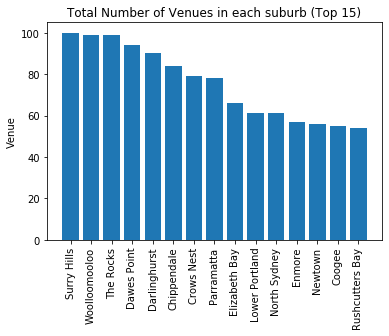

In [125]:
venue_summary = suburb_venues.groupby('Suburb').count()
venue_summary = venue_summary.loc[:,['Venue']]
venue_summary = venue_summary.sort_values(['Venue'], ascending=False).reset_index(drop=False)
venue_summary['Suburb'] = venue_summary['Suburb'].str.title()
print('There are a total of {} Suburbs returned from the FourSquare API analysis.'.format(venue_summary.shape[0]))

suburb_name_top = venue_summary.Suburb[:15]
venue_count_top = venue_summary.Venue[:15]

suburb_name_bottom = venue_summary.Suburb[-15:]
venue_count_bottom = venue_summary.Venue[-15:]

y_pos = np.arange(len(suburb_name))

plt.bar(y_pos, venue_count_top, align='center')
plt.xticks(y_pos, suburb_name_top)
plt.ylabel('Venue')
plt.title('Total Number of Venues in each suburb (Top 15)')
plt.xticks(rotation=90)

plt.show()


Here we can see that Surry Hills, Woolloomooloo, The Rocks, Dawes Point all have venue numbers close to the top limit of 100 venues. It is not surprising to us as they are all popular locations within the CBD area (heavier population density).

Let's see how many unique categories have been returned by the FourSquare API query.

In [126]:
print('There are {} uniques categories.'.format(len(suburb_venues['Venue Category'].unique())))

There are 358 uniques categories.


We use one-hot encoding to create a table to analyse venue information for each suburb.

In [129]:
# one hot encoding
sydney_onehot = pd.get_dummies(suburb_venues[['Venue Category']], prefix="", prefix_sep="")

# add the suburb column back to dataframe
sydney_onehot['Suburb'] = suburb_venues['Suburb'] 

# move the suburb column to the first column
one_hot_col_list = [sydney_onehot.columns[-1]] + list(sydney_onehot.columns[:-1])
sydney_onehot = sydney_onehot[one_hot_col_list]

sydney_onehot.head()

Suburb  ATM  Advertising Agency  Afghan Restaurant  African Restaurant  \
0  Abbotsbury    0                   0                  0                   0   
1  Abbotsbury    0                   0                  0                   0   
2  Abbotsford    0                   0                  0                   0   
3  Abbotsford    0                   0                  0                   0   
4  Abbotsford    0                   0                  0                   0   

   Airport  American Restaurant  Amphitheater  Antique Shop  Arcade  \
0        0                    0             0             0       0   
1        0                    0             0             0       0   
2        0                    0             0             0       0   
3        0                    0             0             0       0   
4        0                    0             0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Astrologer  Athletics & Sports  \
0                    0                 0           0                   0   
1                    0                 0           0                   0   
2                    0                 0           0                   0   
3                    0                 0           0                   0   
4                    0                 0           0                   0   

   Australian Restaurant  Austrian Restaurant  Auto Dealership  Auto Garage  \
0                      0                    0                0            0   
1                      0                    0                0            0   
2                      0                    0                0            0   
3                      0                    0                0            0   
4                      0                    0                0            0   

   Auto Workshop  Automotive Shop  BBQ Joint  Badminton Court  Bagel Shop  \
0              0                0          0                0           0   
1              0                0          0                0           0   
2              0                0          0                0           0   
3              0                0          0                0           0   
4              0                0          0                0           0   

   Bakery  Bar  Baseball Field  Basketball Court  Basketball Stadium  \
0       0    0               0                 0                   0   
1       0    0               0                 0                   0   
2       0    0               0                 0                   0   
3       0    0               0                 0                   0   
4       0    0               0                 0                   0   

   Bathing Area  Bay  Beach  Beach Bar  Bed & Breakfast  Beer Bar  \
0             0    0      0          0                0         0   
1             0    0      0          0                0         0   
2             0    0      0          0                0         0   
3             0    0      0          0                0         0   
4             0    0      0          0                0         0   

   Beer Garden  Beer Store  Betting Shop  Big Box Store  \
0            0           0             0              0   
1            0           0             0              0   
2            0           0             0              0   
3            0           0             0              0   
4            0           0             0              0   

   Bike Rental / Bike Share  Bistro  Board Shop  Boat Rental  

We then group by Suburbs and take the average of the occurrence frequency of each category.

In [131]:
sydney_onehot_grouped = sydney_onehot.groupby('Suburb').mean().reset_index()
sydney_onehot_grouped.head()

Suburb  ATM  Advertising Agency  Afghan Restaurant  \
0        Abbotsbury  0.0                 0.0                0.0   
1        Abbotsford  0.0                 0.0                0.0   
2        Alexandria  0.0                 0.0                0.0   
3     Alfords Point  0.0                 0.0                0.0   
4  Allambie Heights  0.0                 0.0                0.0   

   African Restaurant  Airport  American Restaurant  Amphitheater  \
0                 0.0      0.0                  0.0           0.0   
1                 0.0      0.0                  0.0           0.0   
2                 0.0      0.0                  0.0           0.0   
3                 0.0      0.0                  0.0           0.0   
4                 0.0      0.0                  0.0           0.0   

   Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0           0.0     0.0               0.0                     0.0   
1           0.0     0.0               0.0                     0.0   
2           0.0     0.0               0.0                     0.0   
3           0.0     0.0               0.0                     0.0   
4           0.0     0.0               0.0                     0.0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0          0.0         0.0                  0.0               0.0         0.0   
1          0.0         0.0                  0.0               0.0         0.0   
2          0.0         0.0                  0.0               0.0         0.0   
3          0.0         0.0                  0.0               0.0         0.0   
4          0.0         0.0                  0.0               0.0         0.0   

   Athletics & Sports  Australian Restaurant  Austrian Restaurant  \
0                 0.0               0.000000                  0.0   
1                 0.0               0.000000                  0.0   
2                 0.0               0.083333                  0.0   
3                 0.0               0.000000                  0.0   
4                 0.0               0.000000                  0.0   

   Auto Dealership  Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  \
0              0.0          0.0            0.0              0.0        0.0   
1              0.0          0.0            0.0              0.0        0.0   
2              0.0          0.0            0.0              0.0        0.0   
3              0.0          0.0            0.0              0.0        0.0   
4              0.0          0.0            0.0              0.0        0.0   

   Badminton Court  Bagel Shop  Bakery       Bar  Baseball Field  \
0              0.0         0.0     0.0  0.000000             0.0   
1              0.0         0.0     0.0  0.000000             0.0   
2              0.0         0.0     0.0  0.083333             0.0   
3              0.0         0.0     0.0  0.000000             0.0   
4              0.0         0.0     0.0  0.000000             0.0   

   Basketball Court  Basketball Stadium  Bathing Area  Bay  Beach  Beach Bar  \
0               0.0            0.000000           0.0  0.0    0.0        0.0   
1               0.0            0.000000           0.0  0.0    0.0        0.0   
2               0.0            0.083333           0.0  0.0    0.0        0.0   
3               0.0            0.000000           0.0  0.0    0.0        0.0   
4               0.0            0.000000           0.0  0.0    0.0        0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Betting Shop  \
0              0.0       0.0          0.0         0.0           0.0   
1              0.0       0.0          0.0         0.0           0.0   
2              0.0       0.0          0.0         0.0           0.0   
3              0.0       0.0          0.0         0.0           0.0   
4              0.0       0.0          0.0         0.0           0.0   

   Big Box Store  Bike Rental / Bike Share  Bistro  Board Shop  Boat Rental  \
0            

Let's write a function to sort the venues in descending order.

In [134]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [136]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburb'] = sydney_onehot_grouped['Suburb']

for ind in np.arange(sydney_onehot_grouped.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sydney_onehot_grouped.iloc[ind, :], num_top_venues)

suburbs_venues_sorted.head()


Suburb 1st Most Common Venue 2nd Most Common Venue  \
0        Abbotsbury     Convenience Store                  Park   
1        Abbotsford                  Café       Thai Restaurant   
2        Alexandria                  Café           Bus Station   
3     Alfords Point   Fried Chicken Joint  Fast Food Restaurant   
4  Allambie Heights                  Café          Tennis Court   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0   Filipino Restaurant     Electronics Store         Event Service   
1             Wine Shop           Pizza Place                  Park   
2   Lebanese Restaurant                   Bar    Basketball Stadium   
3           Yoga Studio     Fish & Chips Shop         Event Service   
4           Yoga Studio     Electronics Store         Event Service   

  6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0           Event Space     Falafel Restaurant                  Farm   
1           Yoga Studio   Fast Food Restaurant   Egyptian Restaurant   
2           Flea Market  Australian Restaurant    Italian Restaurant   
3           Event Space     Falafel Restaurant                  Farm   
4           Event Space     Falafel Restaurant                  Farm   

  9th Most Common Venue 10th Most Common Venue  
0        Farmers Market   Fast Food Restaurant  
1     Electronics Store          Event Service  
2           Yoga Studio                   Farm  
3        Farmers Market                  Field  
4        Farmers Market   Fast Food Restaurant

### Run k-means to group the suburbs into clusters by their attributes above


First, we use the elbow method to determine what is the optimal number of clusters to form and segment these suburbs.

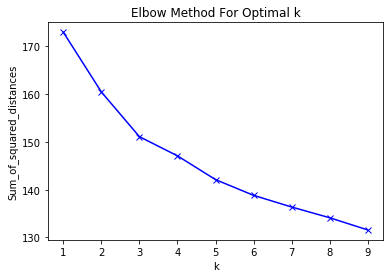

In [145]:
# use for loop to store the sum of euclidean distances of each iteration

suburb_clustering = sydney_onehot_grouped.drop('Suburb', 1)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k,random_state=0)
    km = km.fit(suburb_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It appears that the elbow inflexion point occurs when k=3, hence we will set the number of clusters to form to be 3.

In [146]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(suburb_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 2, 0, 2, 0, 0, 2, 0, 0])

Now we will create a new dataframe that includes the cluster as well as the top 10 venues for each suburb.

In [154]:
# add clustering labels to each suburb (as well as coordinates)
sydney_merged = suburb_venues.groupby('Suburb').mean().reset_index()
sydney_merged.drop(columns=['Venue Latitude','Venue Longitude'],inplace=True)
sydney_merged['Cluster Labels'] = kmeans.labels_

# merge sydney_merged with suburbs_venues_sorted to add top 10 venue info
sydney_merged = pd.merge(sydney_merged,suburbs_venues_sorted,on='Suburb',how='left')

sydney_merged.head() 

Suburb  Suburb Latitude  Suburb Longitude  Cluster Labels  \
0        Abbotsbury       -33.869285        150.866703               1   
1        Abbotsford       -33.850553        151.129759               2   
2        Alexandria       -33.909157        151.192128               2   
3     Alfords Point       -33.983909        151.024161               0   
4  Allambie Heights       -33.770507        151.249675               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Convenience Store                  Park   Filipino Restaurant   
1                  Café       Thai Restaurant             Wine Shop   
2                  Café           Bus Station   Lebanese Restaurant   
3   Fried Chicken Joint  Fast Food Restaurant           Yoga Studio   
4                  Café          Tennis Court           Yoga Studio   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0     Electronics Store         Event Service           Event Space   
1           Pizza Place                  Park           Yoga Studio   
2                   Bar    Basketball Stadium           Flea Market   
3     Fish & Chips Shop         Event Service           Event Space   
4     Electronics Store         Event Service           Event Space   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0     Falafel Restaurant                  Farm        Farmers Market   
1   Fast Food Restaurant   Egyptian Restaurant     Electronics Store   
2  Australian Restaurant    Italian Restaurant           Yoga Studio   
3     Falafel Restaurant                  Farm        Farmers Market   
4     Falafel Restaurant                  Farm        Farmers Market   

  10th Most Common Venue  
0   Fast Food Restaurant  
1          Event Service  
2                   Farm  
3                  Field  
4   Fast Food Restaurant

We will inspect further into this table to see what makes up the composition of the most common venues for each cluster

In [189]:
# Group table by cluster label and then most common venue
count_venues_1st = sydney_merged
count_venues_1st = count_venues_1st.drop(['Suburb','Suburb Latitude', 'Suburb Longitude'], axis=1)
count_venues_1st = count_venues_1st.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Freq')
count_venues_1st = count_venues_1st[count_venues_1st['Freq']>4]

# We will use pivot table to illustrate the results (venue type vs frequency)
cv_cluster_1 = count_venues_1st.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Freq')
# fill NaN with zero values
cv_cluster_1 = cv_cluster_1.fillna(0).astype(int).reset_index(drop=True)

cv_cluster_1

1st Most Common Venue  Bakery  Beach  Business Service  Café  \
0                           9      5                 5    18   
1                           0      0                 0     0   
2                           0      0                 0   151   

1st Most Common Venue  Chinese Restaurant  Coffee Shop  \
0                                       8            5   
1                                       0            0   
2                                       0            0   

1st Most Common Venue  Construction & Landscaping  Convenience Store  \
0                                               7                 17   
1                                               0                  0   
2                                               0                  0   

1st Most Common Venue  Fast Food Restaurant  Gas Station  Grocery Store  Gym  \
0                                        16            5              9    6   
1                                         0            0              0    0   
2                                         0            0              6    0   

1st Most Common Venue  Harbor / Marina  Home Service  Liquor Store  Park  \
0                                    5             6            10     0   
1                                    0             0             0    31   
2                                    0             0             0     0   

1st Most Common Venue  Pizza Place  Platform  Playground  Pool  Pub  \
0                                9        17           6     6    6   
1                                0         0           0     0    0   
2                                0         0           0     0    0   

1st Most Common Venue  Scenic Lookout  Sports Club  Thai Restaurant  \
0                                   7            9               10   
1                                   0            0                0   
2                                   0            0                0   

1st Most Common Venue  Vietnamese Restaurant  
0                                          5  
1                                          0  
2                                          0

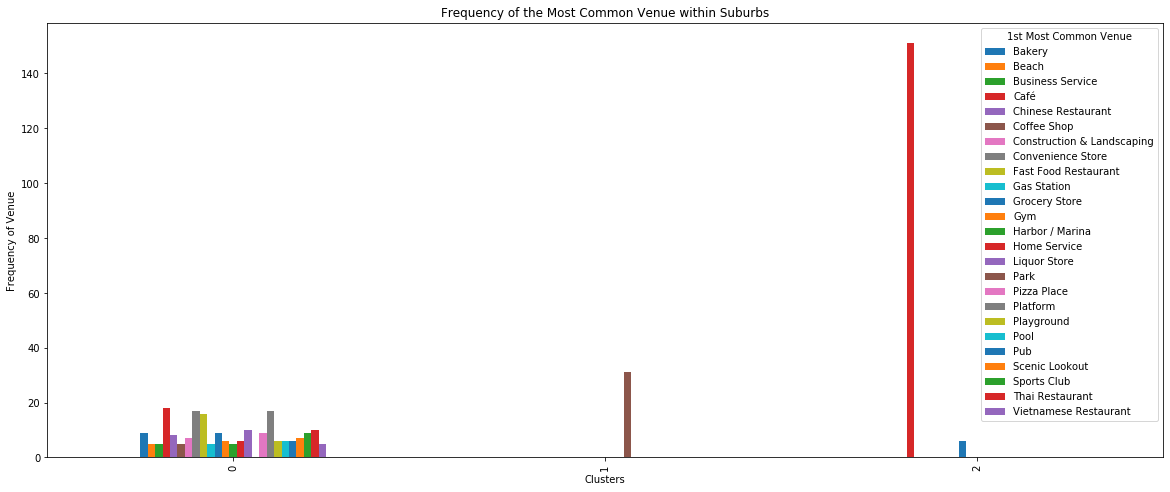

In [194]:
# Plot the pivot chart using column chart
cv_cluster_1.plot(kind='bar',figsize=(20,8))
plt.xlabel('Clusters')
plt.ylabel('Frequency of Venue')
plt.title('Frequency of the Most Common Venue within Suburbs')
plt.show()

On initial inspection, it seems that the clusters can be classfied into 3 main categories:

- **Category/Cluster 0**: Convenience Store, Fast Food Restaurant, Liquor Store, Platform

- **Category/Cluster 1**: Parks

- **Category/Cluster 2**: Cafes, Pubs

Let's now visualise the resulting clusters along with population and age.

In [202]:
latitude = -33.859992
longitude = 151.2083216

# create a plain Sydney map
age_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='cartodbpositron')

# Create a bin to plot age range
bins = [0, 5, 20, 30, 40, 50, 60, 120]

# generate choropleth map using the total population of each suburb in Sydney
folium.Choropleth(
    geo_data=NSW_map,
    data=df_suburb_income_all,
    columns=['Suburbs_boundaries', 'Median_age_persons'],
    key_on='feature.properties.nsw_loca_2',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Age by Suburb',
    bins=bins,
    reset=True
).add_to(age_map)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['Suburb Latitude'], sydney_merged['Suburb Longitude'], sydney_merged['Suburb'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(age_map)

age_map_directory= os.path.join('C:/Work/Jupyter Notebooks/Projects/Coursera_Capstone/Capstone_Restaurant_Sydney', 'GeoJSON_and_choropleth_age_cluster.html')
age_map.save(age_map_directory)


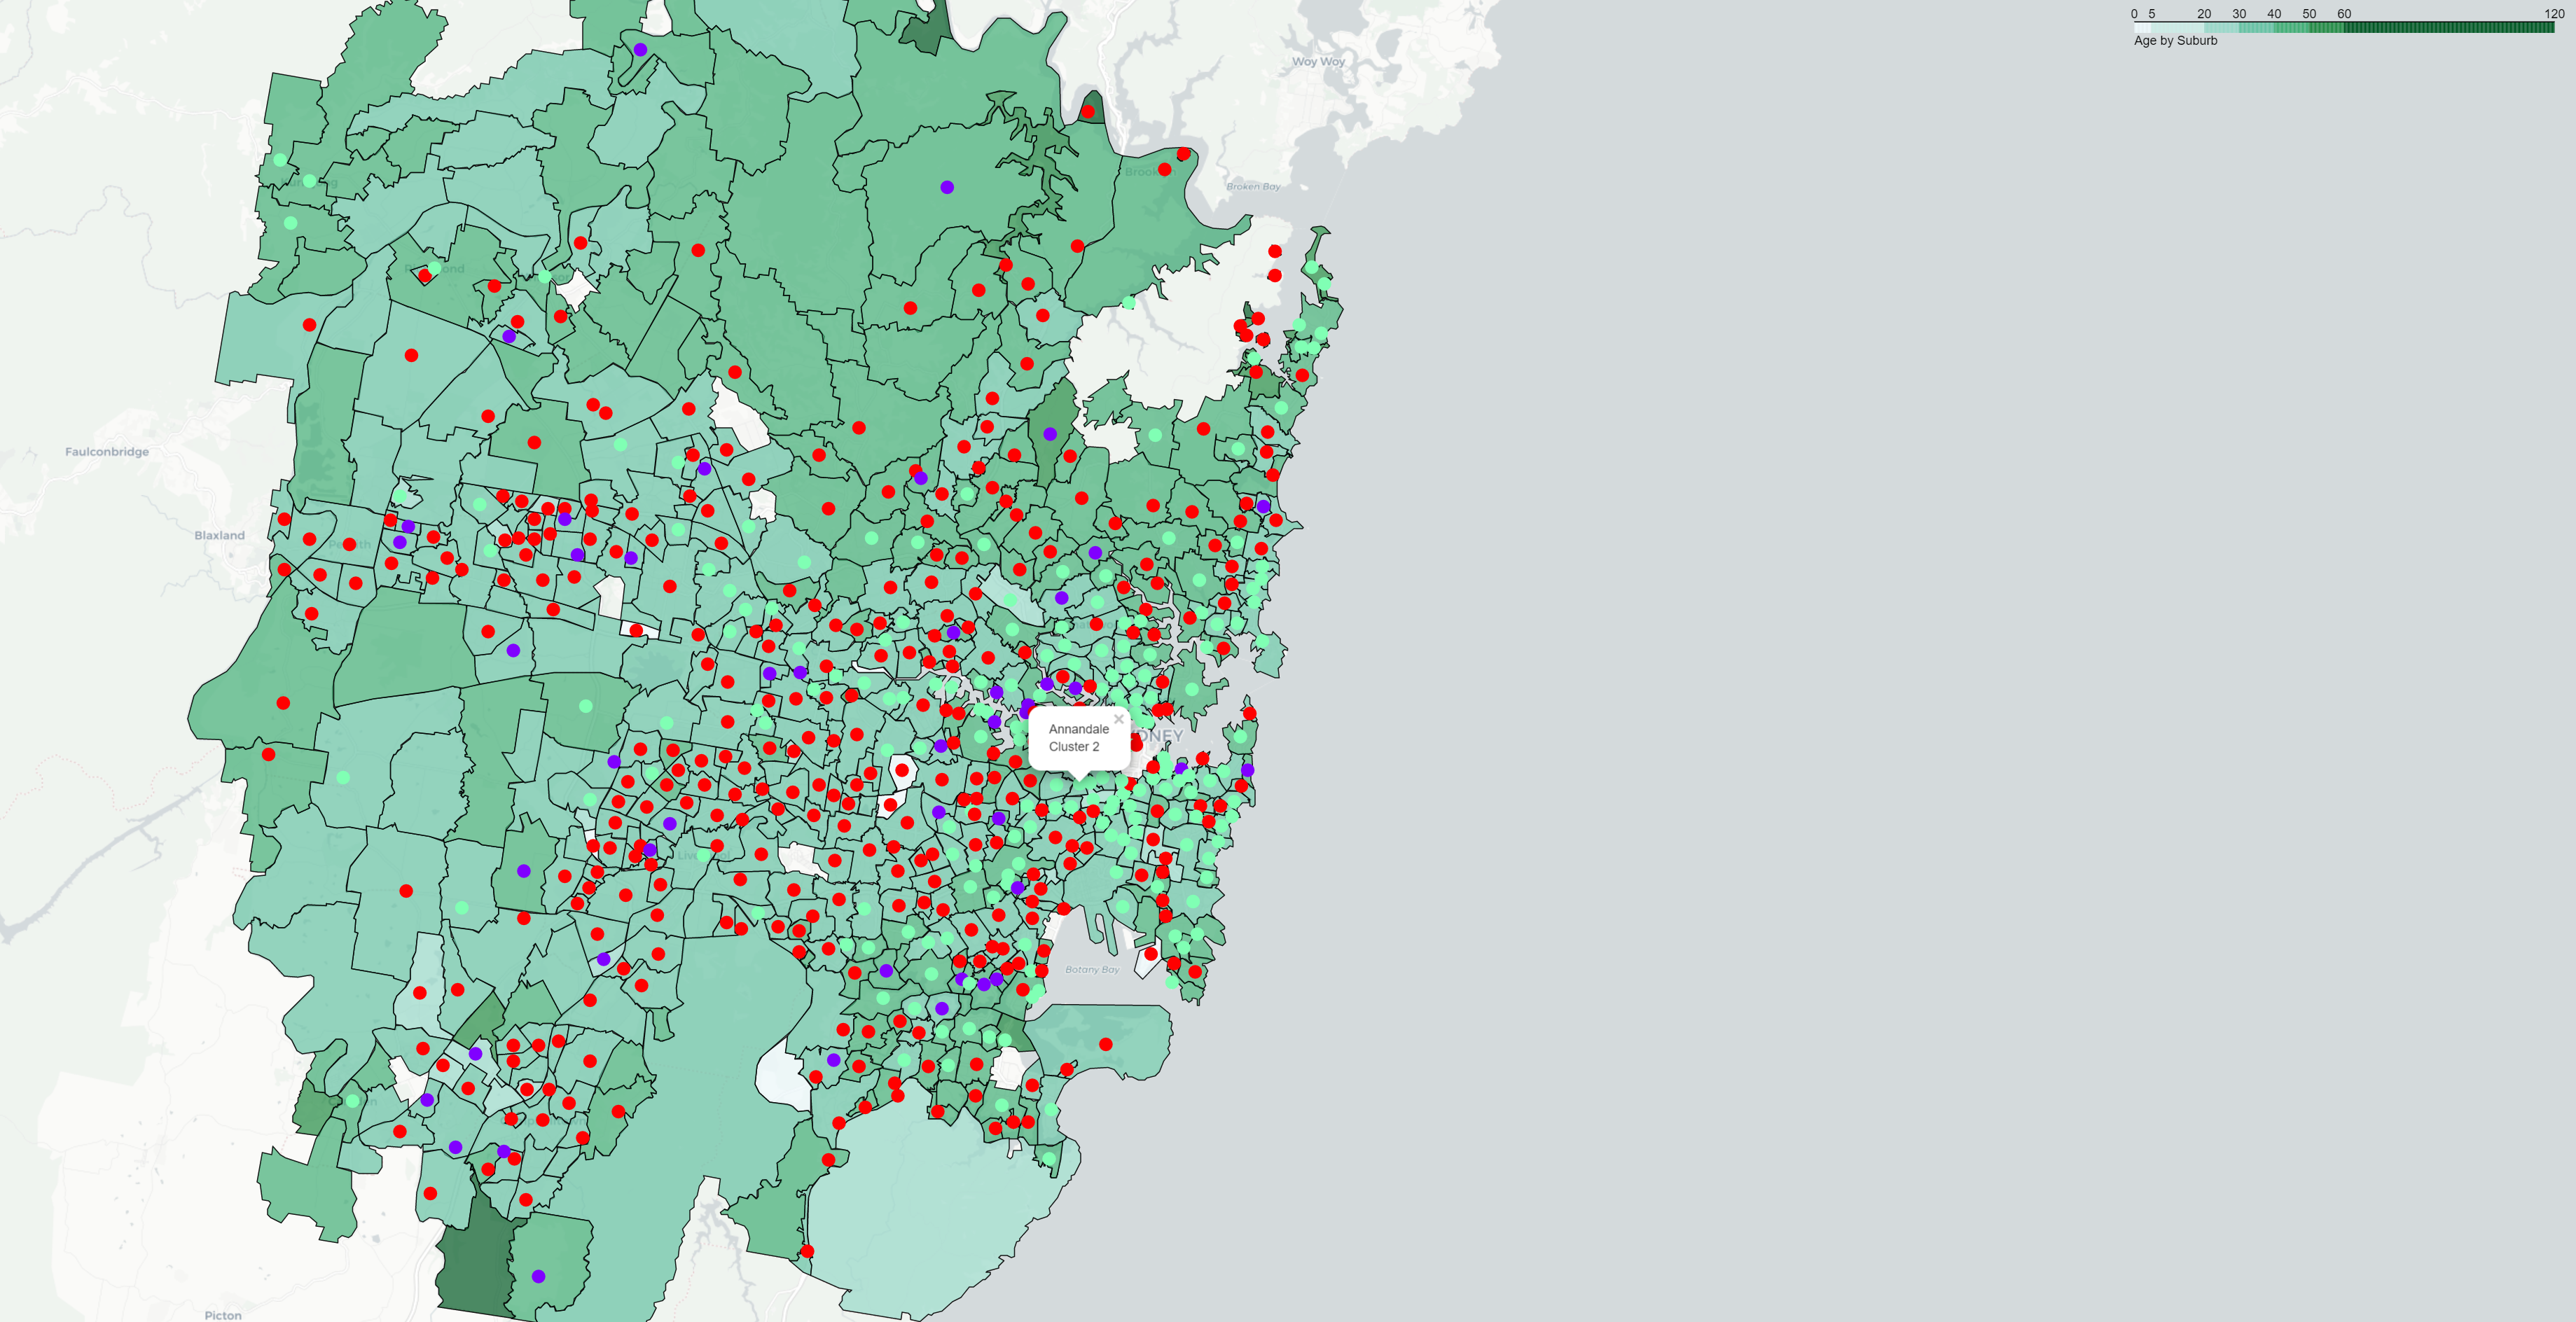

In [219]:
PATH = "Img/"
Image(filename = PATH + "Age_Cluster.png", width=1200, height=800)

In [203]:
latitude = -33.859992
longitude = 151.2083216

# create a plain Sydney map
population_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='cartodbpositron')

# Create a bin to plot age range
bins = list(range(0,50000,5000))

# generate choropleth map using the total population of each suburb in Sydney
folium.Choropleth(
    geo_data=NSW_map,
    data=df_suburb_income_all,
    columns=['Suburbs_boundaries', 'P_Tot_Tot'],
    key_on='feature.properties.nsw_loca_2',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Population by Suburb',
    bins=bins,
    reset=True
).add_to(population_map)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['Suburb Latitude'], sydney_merged['Suburb Longitude'], sydney_merged['Suburb'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(population_map)

population_map_directory= os.path.join('C:/Work/Jupyter Notebooks/Projects/Coursera_Capstone/Capstone_Restaurant_Sydney', 'GeoJSON_and_choropleth_population_cluster.html')
population_map.save(population_map_directory)

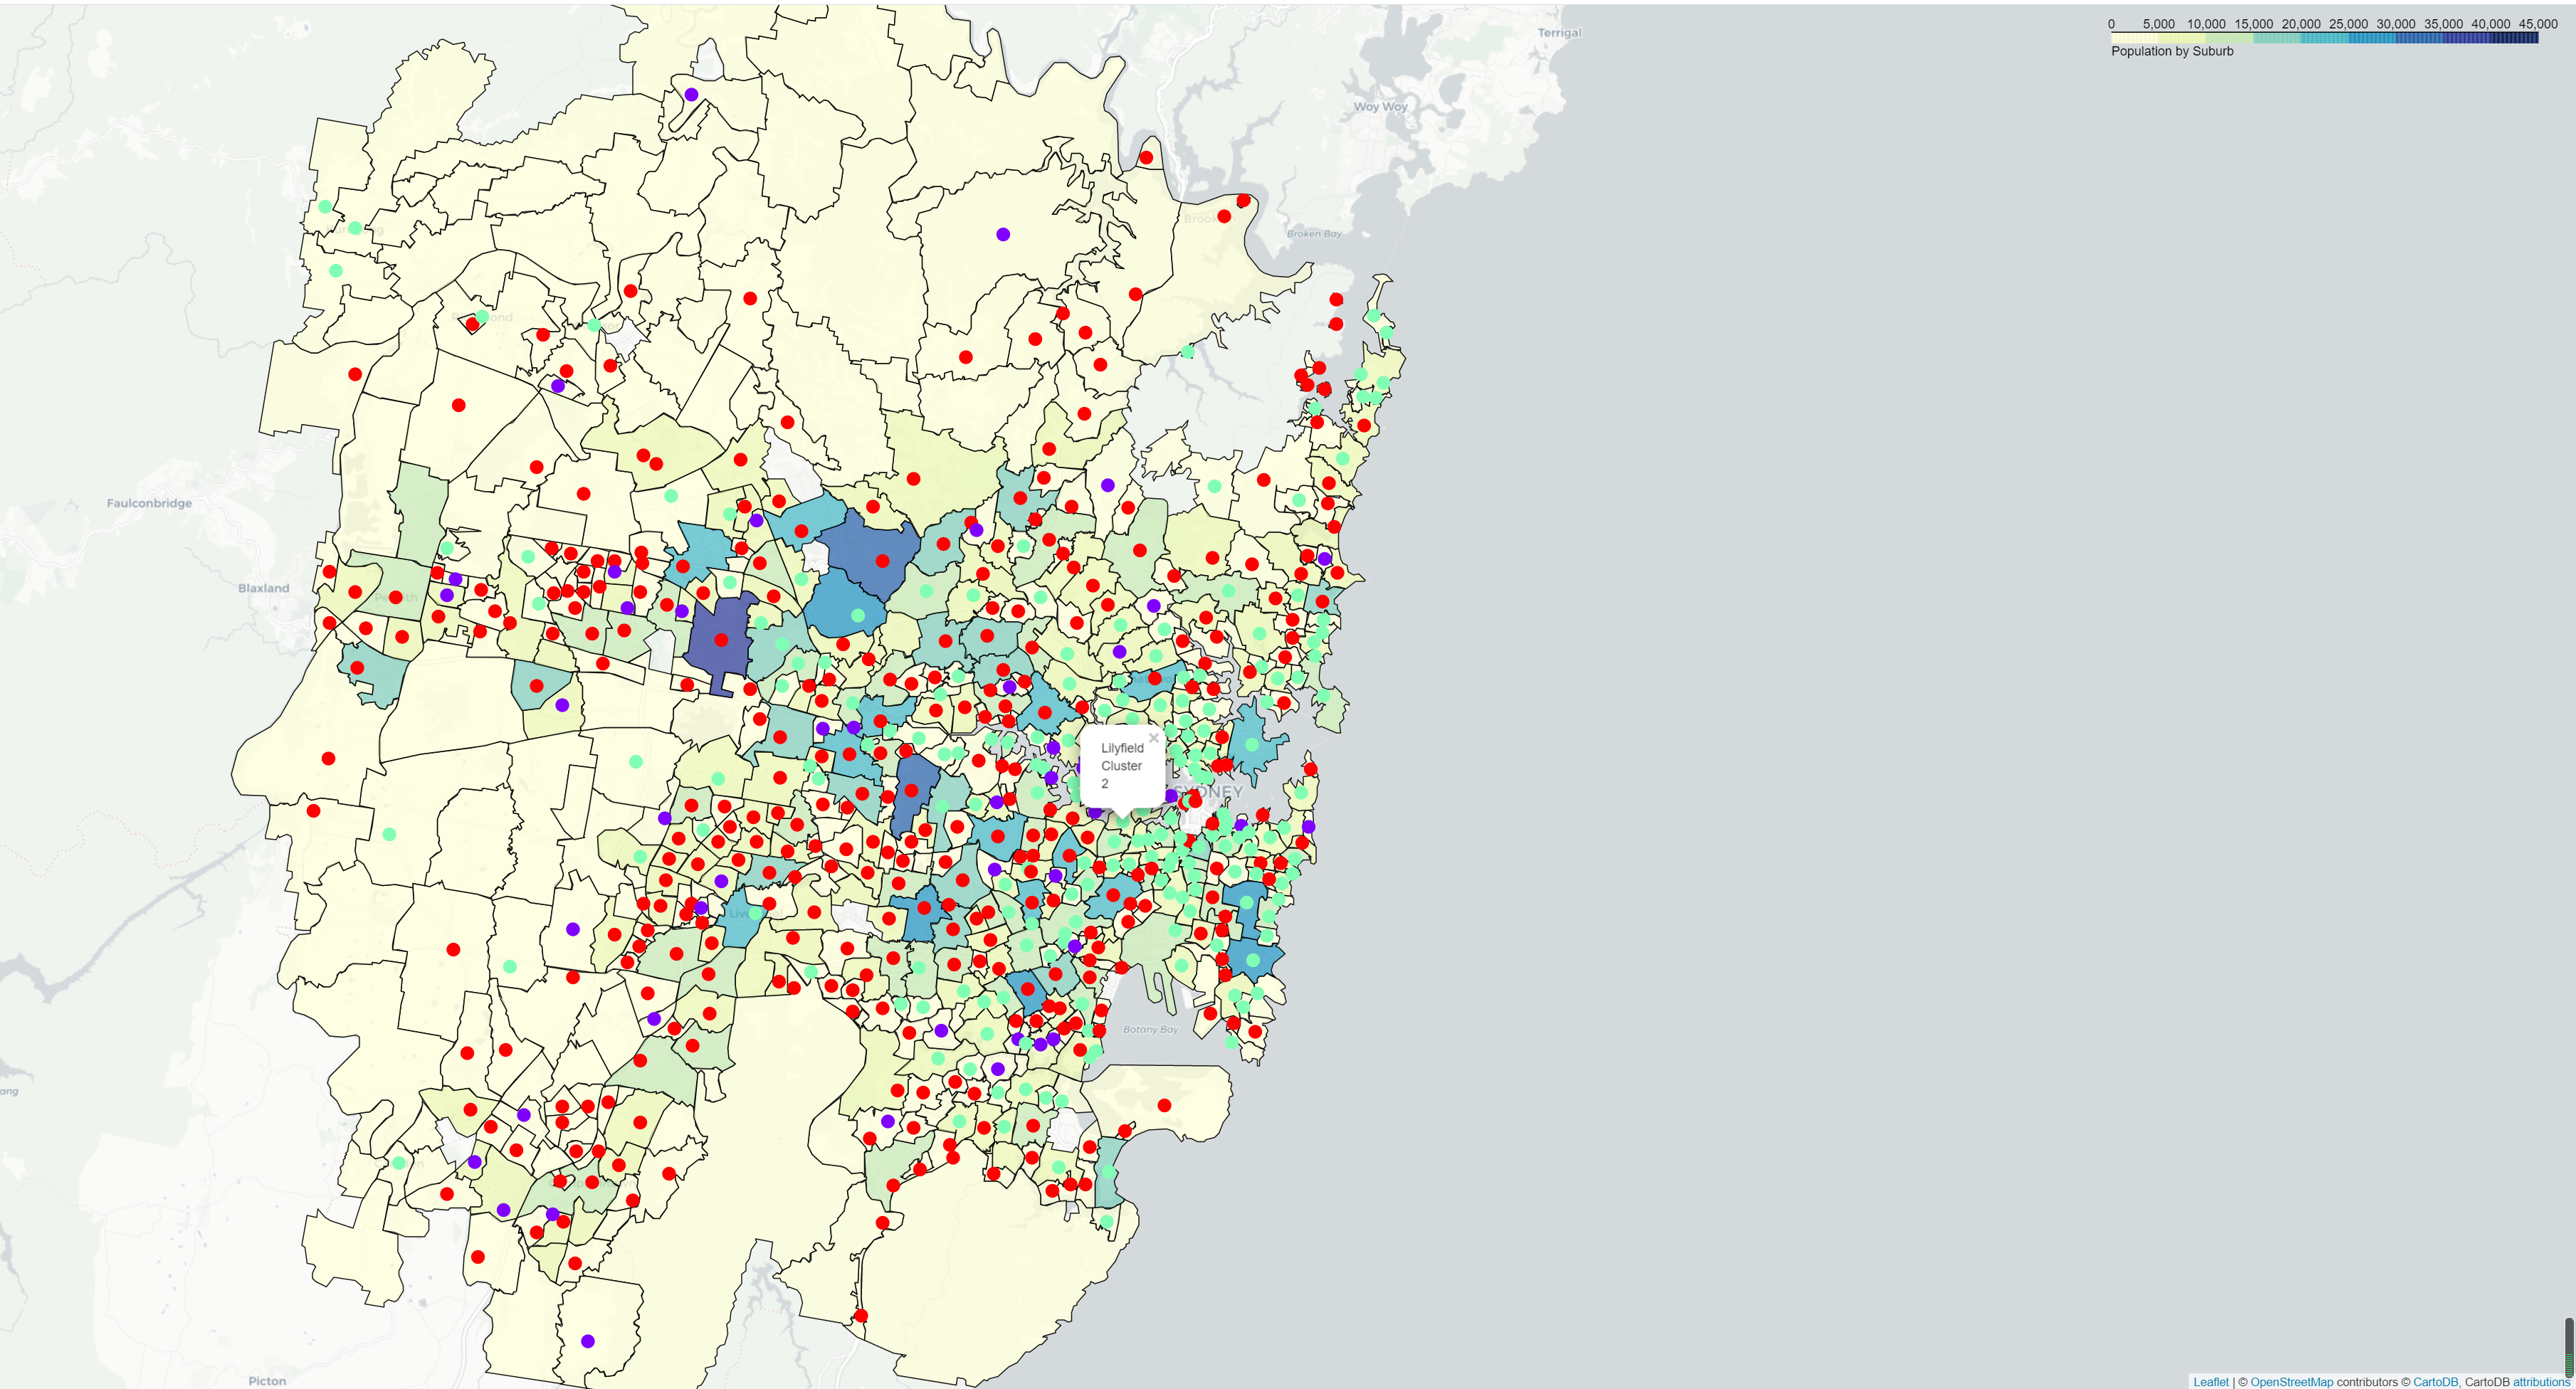

In [220]:
PATH = "Img/"
Image(filename = PATH + "Population_Cluster.png", width=1200, height=800)

We will then examine the composition of each cluster in detail for a better classfication based on its respective category.

**Cluster 0** contains multiple venue types: Fast Food Restaurant, Pizza Place, Platform, Event Service, Convenience Store

In [204]:
column_list= sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]

sydney_merged.loc[sydney_merged['Cluster Labels'] == 0, column_list]

Suburb          1st Most Common Venue  \
3           Alfords Point            Fried Chicken Joint   
5                 Allawah                            Pub   
6               Ambarvale           Gym / Fitness Center   
8              Annangrove                      Racetrack   
9                 Arcadia                            Gym   
10              Arncliffe                         Bakery   
13               Ashfield            Dumpling Restaurant   
14                Asquith                  Train Station   
15                 Auburn               Business Service   
19      Balgowlah Heights                 Scenic Lookout   
22                 Bangor                           Pool   
23                Banksia                       Platform   
24              Bankstown          Vietnamese Restaurant   
25             Barangaroo                            Pub   
30              Bass Hill           Fast Food Restaurant   
32                Bayview           Gym / Fitness Center   
33            Beacon Hill                 Scenic Lookout   
35         Beaumont Hills                  Grocery Store   
41                Belrose                   Soccer Field   
42                 Berala                 Cosmetics Shop   
43         Berkshire Park     Construction & Landscaping   
44                Berowra                    Gas Station   
45          Berowra Creek                          Trail   
46        Berowra Heights                    Supermarket   
47         Berowra Waters             Seafood Restaurant   
48               Berrilee                        Stables   
49          Beverley Park            Sporting Goods Shop   
50          Beverly Hills             Chinese Restaurant   
51                 Bexley              Convenience Store   
53                Bidwill              Convenience Store   
57                Birrong                     Playground   
58               Blackett                         Market   
59              Blacktown               Department Store   
60            Blair Athol                     Playground   
63                  Bondi                    Pizza Place   
65         Bondi Junction                           Café   
66             Bonnet Bay              Food & Drink Shop   
67              Bonnyrigg                   Dessert Shop   
68      Bonnyrigg Heights                   Soccer Field   
69           Bossley Park                            Bar   
72              Bringelly              Convenience Store   
74               Brooklyn                       Platform   
75              Brookvale                      Pet Store   
77              Burraneer                Harbor / Marina   
78                Burwood             Chinese Restaurant   
79        Burwood Heights              Indian Restaurant   
80                  Busby                  Movie Theater   
82             Cabramatta          Vietnamese Restaurant   
83        Cabramatta West                         Bakery   
84      Cambridge Gardens                  Grocery Store   
88           Campbelltown  Paper / Office Supplies Store   
90                Campsie                            Gym   
91             Canada Bay                    Sports Club   
92         Canley Heights          Vietnamese Restaurant   
93            Canley Vale          Vietnamese Restaurant   
94             Canterbury                       Platform   
96            Carlingford                            Gym   
97                Carlton                       Platform   
98            Carnes Hill                   Liquor Store   
99               Carramar                 Ice Cream Shop   
101            Cartwright                      Pet Store   
102           Castle Cove                        Theater   
103           Castle Hill                           Café   
104            Castlecrag                Harbor / Marina   
105                Casula                    Gas Station   
106       Catherine Field                 Baseball Field   

**Cluster 1** contains Parks, Yoga Studio, Eastern European Restaurant, Event Space, Farm

In [205]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 1, column_list]

Suburb       1st Most Common Venue  \
0              Abbotsbury           Convenience Store   
12                Ashbury                        Park   
16                Austral                        Park   
21           Balmain East                        Park   
26           Barden Ridge                        Park   
27                 Bardia                        Café   
29        Bardwell Valley                        Park   
61             Blakehurst          Dim Sum Restaurant   
62             Bligh Park                        Park   
81               Cabarita                       Beach   
85         Cambridge Park                        Park   
100            Carss Park                        Park   
132      Collaroy Plateau                   Pet Store   
137        Connells Point                        Park   
153         Darling Point                        Park   
160             Denistone                    Pharmacy   
168         Dover Heights                  Playground   
176          East Killara                 Yoga Studio   
194         Englorie Park                  Playground   
198          Erskine Park              Rental Service   
206            Fiddletown                        Park   
230         Gregory Hills                        Park   
244                Henley                        Park   
250              Homebush         Sporting Goods Shop   
258         Huntleys Cove                        Park   
311             Lindfield                        Park   
312          Linley Point                        Park   
317           Longueville                        Park   
322               Lugarno                        Park   
338             Mays Hill                        Park   
362           Mount Annan           Outdoor Sculpture   
367       Mount Pritchard                 Bus Station   
370         Narellan Vale  Construction & Landscaping   
391      North Turramurra                         Gym   
397              Oakhurst                 Snack Place   
405            Oyster Bay                        Park   
425              Plumpton           Convenience Store   
453            Rodd Point                        Park   
472       Sackville North                        Park   
473               Sadleir                        Park   
490  South Wentworthville                        Park   
502      Stanhope Gardens                        Park   
505     Strathfield South                        Park   
517        Tennyson Point                        Park   
544            Wedderburn                        Park   
549      Werrington Downs                        Park   
554             Westleigh                        Park   
570             Woodcroft                        Park   

          2nd Most Common Venue        3rd Most Common Venue  \
0                          Park          Filipino Restaurant   
12           Seafood Restaurant                       Market   
16                  Yoga Studio  Eastern European Restaurant   
21                    Gastropub                         Café   
26                   Astrologer                  Yoga Studio   
27                         Park                        Field   
29                Grocery Store                   Playground   
61          Sporting Goods Shop                         Park   
62                Fishing Store           Photography Studio   
81         Gym / Fitness Center                         Park   
85       Thrift / Vintage Store                  Yoga Studio   
100                        Café         Gym / Fitness Center   
132                 IT Services                         Park   
137  Construction & Landscaping                  Bus Station   
153               Boat or Ferry                     Pharmacy   
160                        Park          Filipino Restaurant   
168                        Park                  Yoga Studio   
176                        Park  Eastern European Restaurant   
194      

**Cluster 2** contains Cafes, Pubs and restaurants in multiple cuisines

In [207]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 2, column_list]

Suburb   1st Most Common Venue  2nd Most Common Venue  \
1            Abbotsford                    Café        Thai Restaurant   
2            Alexandria                    Café            Bus Station   
4      Allambie Heights                    Café           Tennis Court   
7             Annandale                    Café          Grocery Store   
11             Artarmon                    Café                 Bakery   
17         Avalon Beach                    Café         Sandwich Place   
18            Balgowlah     Japanese Restaurant                   Café   
20              Balmain                    Café                    Pub   
28        Bardwell Park                     Gym          Train Station   
31       Baulkham Hills                    Café            Pizza Place   
34         Beaconsfield                    Café            Coffee Shop   
36             Beecroft                    Café                   Park   
37             Belfield                    Café            Pizza Place   
38          Bella Vista                    Café            Pizza Place   
39        Bellevue Hill                    Café           Liquor Store   
40              Belmore                    Café            Sports Club   
52         Bexley North           Grocery Store                    Pub   
54        Bilgola Beach                   Beach                   Pool   
55      Bilgola Plateau                    Café                   Park   
56           Birchgrove                    Café                    Pub   
64          Bondi Beach                    Café     Italian Restaurant   
70               Botany                    Café         Ice Cream Shop   
71      Breakfast Point                    Café        Thai Restaurant   
73               Bronte                    Café              Juice Bar   
76             Bundeena                    Café                  Beach   
86               Camden                    Café            Supermarket   
87             Cammeray                    Café    Japanese Restaurant   
89           Camperdown                    Café        Thai Restaurant   
95      Caringbah South                  Bakery                   Café   
107         Cecil Hills                    Café          Shopping Mall   
108     Centennial Park                    Café                   Lake   
110      Chatswood West              Food Court             Steakhouse   
114             Chifley                    Café             Playground   
115         Chippendale                    Café                    Bar   
117            Chiswick         Harbor / Marina           Dance Studio   
119        Church Point                    Café                  Beach   
122          Clareville             Sports Club          Garden Center   
124        Clemton Park                    Café                   Park   
125            Clontarf                    Café            Boat Rental   
126            Clovelly                    Café                  Trail   
129            Cobbitty                    Café          Grocery Store   
133                Como                    Café    Egyptian Restaurant   
134             Concord                    Café     Italian Restaurant   
139              Coogee                    Café                  Hotel   
140       Cottage Point                    Café           Neighborhood   
145            Cronulla                    Café         Ice Cream Shop   
146          Crows Nest                    Café    Japanese Restaurant   
149           Curl Curl                    Café                    Gym   
154        Darlinghurst                    Café    Japanese Restaurant   
155          Darlington                    Café                    Pub   
165         Dolls Point                    Café      Indian Restaurant   
167          Double Bay                    Café    Japanese Restaurant   
169           Drummoyne                    Café                    Pub   
170        Dulwich Hi

Given our purpose is to find the best spot for opening a new spanish restaurant, we will investigate further into Cluster 2.

Namely, we will be looking more in-depth at its population composition using the census data we had previously obtained from ABS.

In [226]:
# we will first merge together Suburb (and cluster labels) with its corresponding demographic attributes.
suburb_cluster_final=pd.merge(sydney_merged[['Suburb','Cluster Labels']],df_suburb_income_all, on='Suburb',how='left')
suburb_cluster_final.head()

Suburb  Cluster Labels   Latitude   Longitude Suburbs_boundaries  \
0        Abbotsbury               1 -33.869285  150.866703         ABBOTSBURY   
1        Abbotsford               2 -33.850553  151.129759         ABBOTSFORD   
2        Alexandria               2 -33.909157  151.192128         ALEXANDRIA   
3     Alfords Point               0 -33.983909  151.024161      ALFORDS POINT   
4  Allambie Heights               2 -33.770507  151.249675   ALLAMBIE HEIGHTS   

  SSC_CODE_2016  Median_age_persons  Median_mortgage_repay_monthly  \
0      SSC10002                  38                           2167   
1      SSC10003                  45                           2600   
2      SSC10030                  33                           2500   
3      SSC10031                  40                           2400   
4      SSC10036                  41                           2902   

   Median_tot_prsnl_inc_weekly  Median_rent_weekly  Median_tot_fam_inc_weekly  \
0                          721                 505                       2175   
1                          965                 520                       2489   
2                         1341                 590                       2904   
3                          841                 740                       2607   
4                          777                 478                       2630   

   Average_num_psns_per_bedroom  Median_tot_hhd_inc_weekly  \
0                           0.9                       2171   
1                           0.9                       2006   
2                           1.1                       2421   
3                           0.8                       2622   
4                           0.9                       2229   

   Average_household_size  P_Tot_Tot AgeGroup Age_map  
0                     3.5       3504    30-39      31  
1                     2.3       4545    40-49      41  
2                     2.1       7390    30-39      31  
3                     3.4       2590    40-49      41  
4                     3.0       5441    40-49      41

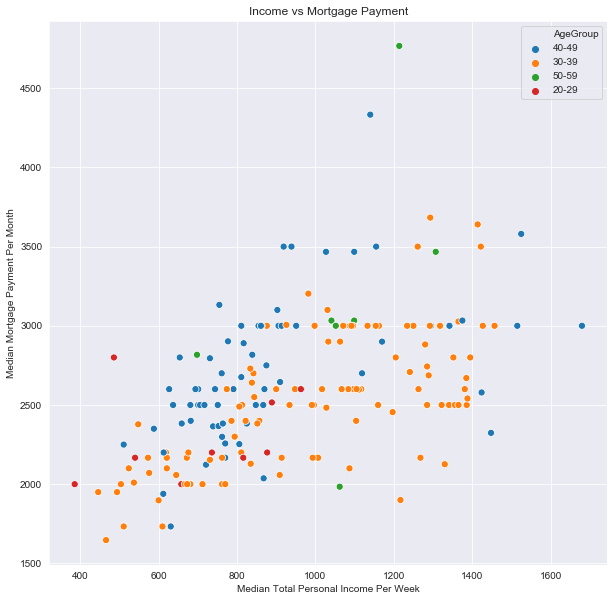

In [241]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
ax = sns.scatterplot(x='Median_tot_prsnl_inc_weekly', y='Median_mortgage_repay_monthly', hue='AgeGroup', s=50,
                     data=suburb_cluster_final[suburb_cluster_final['Cluster Labels'] == 2])
plt.title('Income vs Mortgage Payment')
plt.xlabel('Median Total Personal Income Per Week')
plt.ylabel('Median Mortgage Payment Per Month')
plt.savefig("Income_Mortgage_Age_cluster.png")

We wish to target cvustomers who are more affluent and have more discretionary income to spend to match with our client's target group of customers for the mid-to-high tier of Spanish restaurant.

Hence we will filter the above group further by setting a threshold on **weekly income (the higher the better)** and **monthly mortgage repayment (the lower the better)**. Also, in terms of age, it would be ideal to target **age groups between 30-49** (again based on discretionary spending).

In [240]:
start_idx=potential_suburbs.columns.get_loc('SSC_CODE_2016')
end_idx=potential_suburbs.shape[1]
candidate_col_list = potential_suburbs.columns[[0] + list(range(start_idx, end_idx))]
potential_suburbs=suburb_cluster_final[(suburb_cluster_final['Median_tot_prsnl_inc_weekly']>1200) \
                                       & (suburb_cluster_final['Median_mortgage_repay_monthly']<=2600) \
                                       & (suburb_cluster_final['Median_age_persons']<50) \
                                       & (suburb_cluster_final['Median_age_persons']>=30) \
                                       & (suburb_cluster_final['P_Tot_Tot']>=5000)]

potential_suburbs=potential_suburbs[candidate_col_list]
potential_suburbs

Suburb SSC_CODE_2016  Median_age_persons  \
2        Alexandria      SSC10030                  33   
142        Cremorne      SSC11112                  38   
154    Darlinghurst      SSC11212                  35   
187   Elizabeth Bay      SSC11395                  41   
199    Erskineville      SSC11439                  34   
375     Neutral Bay      SSC12934                  36   
390    North Sydney      SSC13010                  35   
428     Potts Point      SSC13256                  32   
568  Wollstonecraft      SSC14359                  36   

     Median_mortgage_repay_monthly  Median_tot_prsnl_inc_weekly  \
2                             2500                         1341   
142                           2600                         1326   
154                           2500                         1285   
187                           2324                         1448   
199                           2600                         1381   
375                           2500                         1356   
390                           2500                         1322   
428                           2126                         1330   
568                           2541                         1388   

     Median_rent_weekly  Median_tot_fam_inc_weekly  \
2                   590                       2904   
142                 587                       3188   
154                 560                       3095   
187                 493                       3295   
199                 602                       3011   
375                 550                       3098   
390                 560                       2988   
428                 485                       2834   
568                 570                       3157   

     Average_num_psns_per_bedroom  Median_tot_hhd_inc_weekly  \
2                             1.1                       2421   
142                           1.0                       2348   
154                           1.1                       2158   
187                           1.1                       1989   
199                           1.1                       2482   
375                           1.0                       2301   
390                           1.1                       2272   
428                           1.2                       1842   
568                           1.0                       2422   

     Average_household_size  P_Tot_Tot AgeGroup Age_map  
2                       2.1       7390    30-39      31  
142                     2.1       9554    30-39      31  
154                     1.8      10778    30-39      31  
187                     1.5       5005    40-49      41  
199                     2.1       7127    30-39      31  
375                     2.0       9176    30-39      31  
390                     2.0       6902    30-39      31  
428                     1.5       9208    30-39      31  
568                     2.1       7223    30-39      31

It appears that Potts Point, Darlinghurst, Neutral Bay are potential Suburb targets for having relatively lower mortgage repayments, higher personal income and a higher population density. Furthermore, the age group also fits our requirement.

We will now investigate further to see what are the existing types of venues (competition) in each of the suburbs in the table above.

In [249]:
sydney_onehot_sum = sydney_onehot.groupby('Suburb').sum().reset_index()
potential_location_restaurant = sydney_onehot_sum.loc[sydney_onehot_sum['Suburb'].isin(potential_suburbs['Suburb'])]
potential_location_restaurant = potential_location_restaurant.filter(regex='Restaurant', axis=1)
potential_location_restaurant['Suburb'] =potential_suburbs['Suburb']
new_col_list=[potential_location_restaurant.columns[-1]]+list(potential_location_restaurant.columns[:-1])
potential_location_restaurant = potential_location_restaurant[new_col_list]
potential_location_restaurant

Suburb  Afghan Restaurant  African Restaurant  \
2        Alexandria                  0                   0   
142        Cremorne                  0                   0   
154    Darlinghurst                  0                   0   
187   Elizabeth Bay                  0                   0   
199    Erskineville                  0                   0   
375     Neutral Bay                  0                   0   
390    North Sydney                  0                   0   
428     Potts Point                  0                   0   
568  Wollstonecraft                  0                   0   

     American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
2                      0                 0                       0   
142                    0                 0                       0   
154                    1                 0                       0   
187                    0                 0                       0   
199                    0                 0                       0   
375                    0                 0                       0   
390                    1                 0                       0   
428                    0                 0                       0   
568                    0                 0                       0   

     Asian Restaurant  Australian Restaurant  Austrian Restaurant  \
2                   0                      1                    0   
142                 0                      0                    0   
154                 0                      1                    1   
187                 0                      4                    0   
199                 0                      0                    0   
375                 0                      0                    0   
390                 0                      0                    0   
428                 0                      2                    0   
568                 0                      0                    0   

     Brazilian Restaurant  Cambodian Restaurant  Cantonese Restaurant  \
2                       0                     0                     0   
142                     0                     0                     0   
154                     1                     0                     0   
187                     0                     0                     0   
199                     0                     0                     0   
375                     0                     0                     0   
390                     0                     0                     0   
428                     0                     0                     0   
568                     0                     0                     0   

     Caribbean Restaurant  Chinese Restaurant  Colombian Restaurant  \
2                       0                   0                     0   
142                     0                   0                     0   
154                     1                   0                     0   
187                     0                   2                     0   
199                     0                   0                     0   
375                     0                   0                     0   
390                     0                   0                     0   
428                     0                   2                     0   
568                     0                   0                     0   

     Cuban Restaurant  Dim Sum Restaurant  Dumpling Restaurant  \
2                   0                   0                    0   
142                 0                   0                    0   
154                 0                   0                    1   
187                 0                   0                    1   
199                 0                   0                    0   
375                 0                   0                    0   
390                 0                   0                    0   
428                 0         

In [255]:
# print top 5 venues for each suburbs above by frequency

for suburb in list(potential_location_restaurant.index):
    print('*******'+potential_location_restaurant.loc[suburb,:][0]+'*******')
    print(potential_location_restaurant.loc[suburb,:][1:].sort_values(ascending=False).head(5))
    print('\n')

*******Alexandria*******
Italian Restaurant       1
Australian Restaurant    1
Lebanese Restaurant      1
Vietnamese Restaurant    0
Greek Restaurant         0
Name: 2, dtype: object


*******Cremorne*******
Japanese Restaurant      1
Korean Restaurant        1
Fast Food Restaurant     1
Sushi Restaurant         1
Vietnamese Restaurant    0
Name: 142, dtype: object


*******Darlinghurst*******
Japanese Restaurant      7
Italian Restaurant       6
Vietnamese Restaurant    3
Thai Restaurant          3
Seafood Restaurant       2
Name: 154, dtype: object


*******Elizabeth Bay*******
Australian Restaurant    4
Italian Restaurant       4
Chinese Restaurant       2
Thai Restaurant          2
Japanese Restaurant      2
Name: 187, dtype: object


*******Erskineville*******
Thai Restaurant          2
Turkish Restaurant       1
Seafood Restaurant       1
Vietnamese Restaurant    0
French Restaurant        0
Name: 199, dtype: object


*******Neutral Bay*******
Japanese Restaurant      4
Thai Rest

It seems that judging by the results above, Spanish restaurants are not common in any of the suburbs which is great news for our client. Judging by different factors, Potts Point seems to be the winning candidate here with low number of restaurants (lower competition), lower mortgage payment relative to income (higher discretionary income) and a higher density in terms of population.

## Results and Discussion

Using modern data analytic tools, we began the investigation for our client from using searching online for relevant data sources in ABS Census data, conducting web-scraping and utilise python library to condition our data for us to being our analysis. With techniques such as unsupervised learning technique such as K-Means clustering and visualisation tools such as Folium, we were able to better our candidate suburb in terms of its demographic attributes and venue composition. We have come up with recommendation of Potts Point as the recommended suburb out of a candidate pool of 9 suburbs. As stated earlier, its demographic factors appeal to our niche need, at the same time, its location is also very appealing for food diners as it is close to the sea with good proximity to a breath-taking view of the Cowper Wharf and Sydney Harbour.

## Conclusion

Despite coming up with a recommendation of suburb based on data analytic tools, we have to admit that it is still primitive in nature as we were only able to consider only a few of the factors stated in the Data section. To open a restaurant would take much more in-depth analysis including traffic flow, parking, crime rates, all of which could be things used in future research. In addition, FourSquare API, being an American API seems somehwat mediocre in picking up existing venues in Sydney/Australia, a better alternative would have been paid service offered by Google Map API which should be more up-to-date and comprehensive.

Hopefully, with the analysis above, reader can see some of the immediate benefits being offered by data science and tools offered by data analytics package within Python in tackling real and practical problems to derive insights.